In [1]:
import os
import coremltools as ct
import onnx
import urllib
import numpy as np

In [2]:
onnx_model_url = 'https://github.com/onnx/models/blob/main/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx'


onnx_model_path = './models/tinyyolov2-8.onnx'
cml_model_path = './models/tinyyolov2-8.mlmodel'

In [ ]:
if os.path.exists(onnx_model_path) == False:
    urllib.request.urlretrieve(onnx_model_url, filename=onnx_model_path)

In [3]:
with open(onnx_model_path, 'rb') as f:
    model_onnx = onnx.load(f)

In [4]:
print(model_onnx.graph.input)

[name: "image"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "None"
        denotation: "DATA_BATCH"
      }
      dim {
        dim_value: 3
        denotation: "DATA_CHANNEL"
      }
      dim {
        dim_value: 416
        denotation: "DATA_FEATURE"
      }
      dim {
        dim_value: 416
        denotation: "DATA_FEATURE"
      }
    }
  }
  denotation: "IMAGE"
}
doc_string: "Input image. Image(s) in RGB format. It is a [N, C, H, W]-tensor. The 1st/2nd/3rd slices along the C-axis are red, green, and blue channels, respectively."
, name: "scalerPreprocessor_scale"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
    }
  }
}
, name: "scalerPreprocessor_bias"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 1
      }
    }
  }
}
, name: "convolution_W"
type {
  tensor_type {
    elem_ty

In [5]:
print(model_onnx.graph.output)

[name: "grid"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "None"
      }
      dim {
        dim_value: 125
      }
      dim {
        dim_value: 13
      }
      dim {
        dim_value: 13
      }
    }
  }
}
doc_string: "The 13x13 grid with the bounding box data"
]


In [7]:
INPUT_NODE = model_onnx.graph.input[0].name
OUTPUT_NODE = model_onnx.graph.output[0].name
print(f'input = {INPUT_NODE} output ={OUTPUT_NODE}')

input = image output =grid


In [8]:
cml_model = ct.converters.onnx.convert(
    model=onnx_model_path,
    image_input_names=[INPUT_NODE],
    preprocessing_args={
        'image_scale': 1/255.0,
            'is_bgr': False
    },
    minimum_ios_deployment_target='13', 
)

1/33: Converting Node Type Mul
2/33: Converting Node Type Add
3/33: Converting Node Type Conv
4/33: Converting Node Type BatchNormalization
5/33: Converting Node Type LeakyRelu
6/33: Converting Node Type MaxPool
7/33: Converting Node Type Conv
8/33: Converting Node Type BatchNormalization
9/33: Converting Node Type LeakyRelu
10/33: Converting Node Type MaxPool
11/33: Converting Node Type Conv
12/33: Converting Node Type BatchNormalization
13/33: Converting Node Type LeakyRelu
14/33: Converting Node Type MaxPool
15/33: Converting Node Type Conv
16/33: Converting Node Type BatchNormalization
17/33: Converting Node Type LeakyRelu
18/33: Converting Node Type MaxPool
19/33: Converting Node Type Conv
20/33: Converting Node Type BatchNormalization
21/33: Converting Node Type LeakyRelu
22/33: Converting Node Type MaxPool
23/33: Converting Node Type Conv
24/33: Converting Node Type BatchNormalization
25/33: Converting Node Type LeakyRelu
26/33: Converting Node Type MaxPool
27/33: Converting Nod

In [9]:
print(cml_model)

input {
  name: "image"
  type {
    imageType {
      width: 416
      height: 416
      colorSpace: RGB
    }
  }
}
output {
  name: "grid"
  type {
    multiArrayType {
      shape: 0
      shape: 125
      shape: 13
      shape: 13
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "onnx==1.7.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}



In [10]:
cml_model.save(cml_model_path)

In [11]:
from PIL import Image

def load_and_scale_image(image_url):
    image = Image.open(urllib.request.urlopen(image_url))
    w,h = image.size
    min_dim = min(w,h)
    x0 = int((w - min_dim)/2)
    y0 = int((h - min_dim)/2)
    box = (x0, y0, x0 + min_dim, y0 + min_dim)
    return image.crop(box=box).resize((416,416))

def load_local_and_scale_image(image_path):
    image = Image.open(image_path)
    w,h = image.size
    min_dim = min(w,h)
    x0 = int((w - min_dim)/2)
    y0 = int((h - min_dim)/2)
    box = (x0, y0, x0 + min_dim, y0 + min_dim)
    return image.crop(box=box).resize((416,416))

In [12]:
GRID_SIZE = 13
CELL_SIZE = int(416 / GRID_SIZE)
BOXES_PER_CELL = 5

ANCHORS = [[0.57273, 0.677385], 
           [1.87446, 2.06253], 
           [3.33843, 5.47434], 
           [7.88282, 3.52778], 
           [9.77052, 9.16828]]

In [13]:
with open('coco.txt', 'r') as f:
    COCO_CLASSES = [c.strip() for c in f.readlines()]
    
COCO_CLASSES[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [14]:
def sigmoid(x):
    k = np.exp(-x)
    return 1 / (1 + k)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

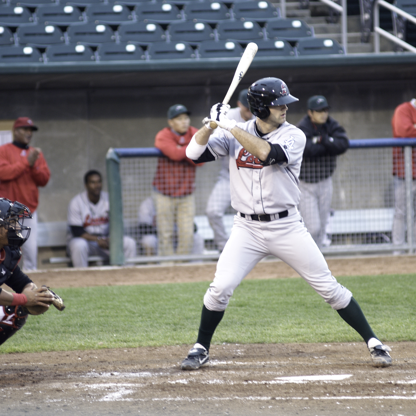

In [15]:
image = load_and_scale_image('https://c1.staticflickr.com/6/5107/5656028725_738189efa2_o.jpg')
image

In [16]:
cml_model = ct.models.MLModel(cml_model_path)

In [34]:
preds = cml_model.predict(data={INPUT_NODE: image})[OUTPUT_NODE]

In [38]:
print(preds.shape)

(1, 1, 125, 13, 13)


In [36]:
def decode_preds(raw_preds: []):
    num_classes = len(COCO_CLASSES)
    decoded_preds = []
    for cy in range(GRID_SIZE):
        for cx in range(GRID_SIZE):
            for b in range(BOXES_PER_CELL):
                print(f'cy ={cy}--- cx ={cx} --- b={b}')
                box_shift = b*(20 + 5)
            
                tx = float(raw_preds[0, box_shift    , cy, cx])
                ty = float(raw_preds[0, box_shift + 1, cy, cx])
                tw = float(raw_preds[0, box_shift + 2, cy, cx])
                th = float(raw_preds[0, box_shift + 3, cy, cx])
                ts = float(raw_preds[0, box_shift + 4, cy, cx])

                x = (float(cx) + sigmoid(tx)) * CELL_SIZE
                y = (float(cy) + sigmoid(ty)) * CELL_SIZE
            
                w = np.exp(tw) * ANCHORS[b][0] * CELL_SIZE
                h = np.exp(th) * ANCHORS[b][1] * CELL_SIZE
            
                box_confidence = sigmoid(ts)
                classes_raw = raw_preds[0, box_shift + 5:box_shift + 5 + num_classes, cy, cx]
                classes_confidence = softmax(classes_raw)
            
                box_class_idx = np.argmax(classes_confidence)
                box_class_confidence = classes_confidence[box_class_idx]

                combined_confidence = box_confidence * box_class_confidence
            
                decoded_preds.append([box_class_idx, combined_confidence, x, y, w, h])            
    
    return sorted(decoded_preds, key=lambda p: p[1], reverse=True)

In [39]:
decoded_preds = decode_preds(preds[0])

cy =0--- cx =0 --- b=0
cy =0--- cx =0 --- b=1
cy =0--- cx =0 --- b=2
cy =0--- cx =0 --- b=3
cy =0--- cx =0 --- b=4
cy =0--- cx =1 --- b=0
cy =0--- cx =1 --- b=1
cy =0--- cx =1 --- b=2
cy =0--- cx =1 --- b=3
cy =0--- cx =1 --- b=4
cy =0--- cx =2 --- b=0
cy =0--- cx =2 --- b=1
cy =0--- cx =2 --- b=2
cy =0--- cx =2 --- b=3
cy =0--- cx =2 --- b=4
cy =0--- cx =3 --- b=0
cy =0--- cx =3 --- b=1
cy =0--- cx =3 --- b=2
cy =0--- cx =3 --- b=3
cy =0--- cx =3 --- b=4
cy =0--- cx =4 --- b=0
cy =0--- cx =4 --- b=1
cy =0--- cx =4 --- b=2
cy =0--- cx =4 --- b=3
cy =0--- cx =4 --- b=4
cy =0--- cx =5 --- b=0
cy =0--- cx =5 --- b=1
cy =0--- cx =5 --- b=2
cy =0--- cx =5 --- b=3
cy =0--- cx =5 --- b=4
cy =0--- cx =6 --- b=0
cy =0--- cx =6 --- b=1
cy =0--- cx =6 --- b=2
cy =0--- cx =6 --- b=3
cy =0--- cx =6 --- b=4
cy =0--- cx =7 --- b=0
cy =0--- cx =7 --- b=1
cy =0--- cx =7 --- b=2
cy =0--- cx =7 --- b=3
cy =0--- cx =7 --- b=4
cy =0--- cx =8 --- b=0
cy =0--- cx =8 --- b=1
cy =0--- cx =8 --- b=2
cy =0--- cx

In [40]:
decoded_preds[:20]

[[19,
  0.0037513119456106603,
  205.46299480595607,
  239.25347211869362,
  279.01764545709426,
  386.96764004077903],
 [19,
  0.003746073072769033,
  237.4877532646407,
  239.23447166998065,
  279.05170730719624,
  386.77873712042054],
 [19,
  0.0036929583284926824,
  205.45537931937514,
  207.25834437068994,
  279.23912182409566,
  386.96764004077903],
 [19,
  0.003690365117005526,
  173.4458616246849,
  239.25931883765975,
  279.08577331549276,
  387.06212609574635],
 [19,
  0.003678140740826012,
  237.46489886200163,
  207.23154871474327,
  279.3414009714137,
  386.6843202437699],
 [19,
  0.003666701775522988,
  173.45347563239247,
  175.28124578663878,
  279.13688012566257,
  385.45899618523947],
 [19,
  0.003662042113171594,
  141.46489886200163,
  175.27734746227708,
  279.13688012566257,
  385.8356048472197],
 [19,
  0.0036610144294142847,
  141.41731969371696,
  239.28611881228417,
  279.0687397915385,
  386.96764004077903],
 [19,
  0.003659240759896927,
  173.46870719500595,

In [32]:
import copy
from PIL import ImageDraw, ImageColor

def annotate_image(image, preds, min_score=0.0005, top=20):
    annotated_image = copy.deepcopy(image)
    draw = ImageDraw.Draw(annotated_image)
    w,h = image.size
    
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'white']
    
    for class_id, score, xc, yc, w, h in preds[:top]:
        if score < min_score:
            continue
        class_id = int(class_id)
        label = COCO_CLASSES[class_id]
            
        x0 = xc - (w / 2)
        y0 = yc - (h / 2)
        color = ImageColor.colormap[colors[class_id % len(colors)]]
        draw.rectangle([(x0, y0), (x0 + w, y0 + h)], width=2, outline=color)
        draw.text((x0 + 5, y0 + 5), "{} {:0.2f}".format(label, score), fill=color)
    
    return annotated_image

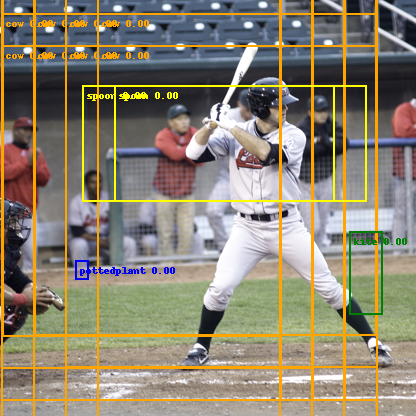

In [33]:
annotate_image(image, decoded_preds)